# Pipeline en scikit-learn
Un Pipeline en scikit-learn es una herramienta que permite encadenar múltiples etapas de procesamiento y modelado de datos dentro de un único flujo. Esto incluye desde la preparación de datos (limpieza, transformación, selección de características) hasta el entrenamiento y predicción con un modelo final. Su uso principal es garantizar que todos los pasos del flujo se apliquen de forma consistente tanto en los datos de entrenamiento como en los de prueba, evitando problemas de fuga de datos y asegurando reproducibilidad. Además, al encapsular todo en un solo objeto, el Pipeline puede integrarse fácilmente con técnicas de ajuste de hiperparámetros como GridSearchCV o RandomizedSearchCV, permitiendo optimizar parámetros de cualquier etapa usando una sintaxis uniforme.

En un Pipeline típico, se pueden incluir transformadores como FunctionTransformer para aplicar lógica personalizada (por ejemplo, extracción de año, mes y día desde una fecha), imputadores como SimpleImputer para manejar valores faltantes, escaladores como StandardScaler para normalizar variables numéricas y codificadores como OneHotEncoder para variables categóricas. Para manejar diferentes tipos de variables simultáneamente, se suele utilizar ColumnTransformer, que permite definir sub-pipelines específicos para columnas numéricas y categóricas. También es común integrar pasos de filtrado o selección de variables, como SelectKBest. Finalmente, el estimador final (modelo de Machine Learning) puede ser cualquier algoritmo compatible con scikit-learn, por ejemplo, RandomForestRegressor o LogisticRegression.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score
import joblib

In [2]:
CSV_PATH = "data.csv"  
TARGET   = "Spotify Popularity"  
RANDOM_STATE = 42

In [3]:
def load_csv_robust(path):
    encodings = ["latin-1", "cp1252", "utf-8-sig", "utf-16"]
    for enc in encodings:
        try:
            return pd.read_csv(path, sep=None, engine="python", encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path)

In [4]:
assert Path(CSV_PATH).exists(), f"No existe el archivo: {CSV_PATH}"
df = load_csv_robust(CSV_PATH)

In [5]:
subset_keys = [c for c in ["Track", "Artist", "Release Date"] if c in df.columns]
if subset_keys:
    df = df.drop_duplicates(subset=subset_keys)

In [6]:
if TARGET not in df.columns:
    raise ValueError(f"El target '{TARGET}' no está en el dataset. Columnas: {list(df.columns)}")


In [7]:

df = df[df[TARGET].notna()]

In [8]:
def pre_base_ops(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()

    if "Release Date" in X.columns:
        fecha = pd.to_datetime(X["Release Date"], errors="coerce")
        X["release_year"]  = fecha.dt.year
        X["release_month"] = fecha.dt.month
        X["release_day"]   = fecha.dt.day
        X = X.drop(columns=["Release Date"])

    for col in X.columns:
        if X[col].dtype == "object":
            s = X[col].astype(str).str.replace(",", "", regex=False).str.replace(" ", "", regex=False)
            conv = pd.to_numeric(s, errors="coerce")
            ratio = 1.0 - conv.isna().mean()
            if ratio >= 0.7:  
                X[col] = conv

    return X

In [9]:
pre_base = FunctionTransformer(pre_base_ops, validate=False)

cat_encoder = OneHotEncoder(handle_unknown="ignore", min_frequency=10)

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", cat_encoder),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, selector(dtype_include=np.number)),
        ("cat", cat_pipe, selector(dtype_include=object)),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [10]:
y = df[TARGET]
X = df.drop(columns=[TARGET])

In [12]:
is_classification = (
    (y.dtype.kind in "iu" and y.nunique() <= 10) or
    (set(pd.Series(y).dropna().unique()) <= {0, 1})
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y if is_classification and y.nunique() > 1 else None
)

In [13]:
if is_classification:
    score_fn = f_classif
    model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
else:
    score_fn = f_regression
    model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [14]:
sel = SelectKBest(score_func=score_fn, k="all")  

In [15]:
pipe = Pipeline(steps=[
    ("pre_base", pre_base),
    ("pre", preprocessor),
    ("sel", sel),
    ("model", model)
])

if is_classification:
    scoring = "accuracy"
    param_grid = {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2]
    }
else:
    scoring = "r2"
    param_grid = {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 12, 20],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2]
    }

In [16]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring=scoring,
    verbose=1
)

In [17]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\caste\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\caste\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre_base',
                                        FunctionTransformer(func=<function pre_base_ops at 0x00000150A0B537E0>)),
                                       ('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000150A0B711C0>),
                                                                        (...
                                                          verbose_feature_names_out=False)),
                                       ('sel',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x00000150A09D1580>)),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 12, 20],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [200, 400]},
             scoring='r2', verbose=1)

In [18]:
print(">> Mejores parámetros:", grid.best_params_)

best_pipe = grid.best_estimator_

y_pred_train = best_pipe.predict(X_train)
y_pred_test  = best_pipe.predict(X_test)

>> Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 400}


c:\Users\caste\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\caste\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [19]:
if is_classification:
    acc_tr = accuracy_score(y_train, y_pred_train)
    acc_te = accuracy_score(y_test, y_pred_test)
    f1_tr  = f1_score(y_train, y_pred_train, average="weighted")
    f1_te  = f1_score(y_test, y_pred_test,  average="weighted")
    print(f"Train accuracy: {acc_tr:.4f} | F1: {f1_tr:.4f}")
    print(f"Test  accuracy: {acc_te:.4f} | F1: {f1_te:.4f}")
else:
    r2_tr = r2_score(y_train, y_pred_train)
    r2_te = r2_score(y_test, y_pred_test)
    mae_tr = mean_absolute_error(y_train, y_pred_train)
    mae_te = mean_absolute_error(y_test, y_pred_test)
    print(f"Train R2: {r2_tr:.4f} | MAE: {mae_tr:.4f}")
    print(f"Test  R2: {r2_te:.4f} | MAE: {mae_te:.4f}")

Train R2: 0.9112 | MAE: 2.2462
Test  R2: 0.5707 | MAE: 5.5391


In [ ]:
from sklearn import set_config
import matplotlib.pyplot as plt

set_config(display='diagram')

best_pipe

Pipeline(steps=[('pre_base',
                 FunctionTransformer(func=<function pre_base_ops at 0x00000150A0B537E0>)),
                ('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000150A0BB2840>),
                                                 ('cat',
                                                  Pipeline(steps=[('impu...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=10))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000150A0BB2EA0>)],
                                   verbose_feature_names_out=False)),
                ('sel',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x00000150A09D1580>)),
                ('model',
                 RandomForestRegressor(min_samples_leaf=2, n_estimators=400,
                                       n_jobs=-1, random_state=42))])

# Relación con las primeras etapas de CRISP-DM
En este proyecto, el uso de un Pipeline se enmarca dentro de las dos primeras fases del modelo CRISP-DM: Business Understanding y Data Understanding. En la fase de Business Understanding se definió como objetivo predecir la popularidad de canciones en Spotify para priorizar estrategias de promoción y optimizar recursos de marketing. Se estableció que el criterio de éxito sería alcanzar una métrica R² aceptable (en el caso de regresión) o una precisión adecuada (en el caso de clasificación), teniendo en cuenta restricciones como disponibilidad de datos y tiempo de cómputo. Asimismo, se identificaron riesgos como la posible presencia de datos desbalanceados, sesgos derivados de la popularidad histórica y valores extremos en las métricas de streaming.

En la fase de Data Understanding, se analizó la estructura del dataset, identificando tipos de variables (numéricas, categóricas, fechas) y explorando su distribución y calidad. Se detectaron problemas como duplicados en las columnas clave (Track, Artist, Release Date), valores numéricos almacenados como texto y formatos inconsistentes en fechas. A partir de este análisis, se tomaron decisiones de preparación de datos: eliminación de duplicados y filas sin valor objetivo, creación de variables derivadas como release_year, release_month y release_day, conversión de variables numéricas mal tipadas y uso de un ColumnTransformer para aplicar pipelines específicos a cada tipo de dato. Estas decisiones fueron fundamentales para garantizar que el Pipeline tuviera entradas limpias y consistentes, y que el modelo final recibiera información adecuada para el entrenamiento.

## Pruebas de ejecución

![WhatsApp Image 2025-08-08 at 23.47.57_50a7baa3.jpg](<attachment:WhatsApp Image 2025-08-08 at 23.47.57_50a7baa3.jpg>)
![WhatsApp Image 2025-08-08 at 23.47.57_c84a00f3.jpg](<attachment:WhatsApp Image 2025-08-08 at 23.47.57_c84a00f3.jpg>)
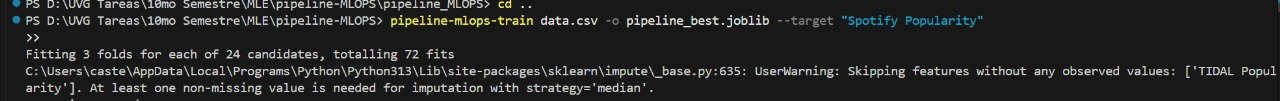
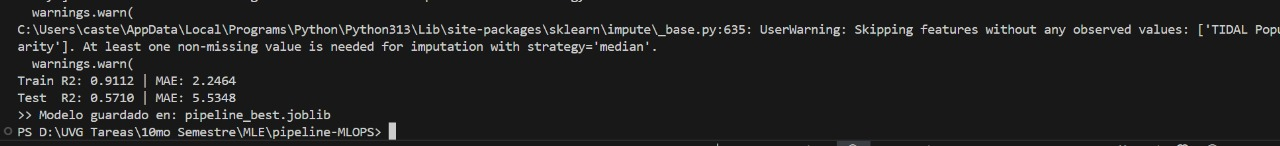

# Referencias
Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

Chapman, P., Clinton, J., Kerber, R., Khabaza, T., Reinartz, T., Shearer, C., & Wirth, R. (2000). CRISP-DM 1.0: Step-by-step data mining guide. SPSS.